# Setup

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

In [2]:
import os

PATH = 'data'
DATA_ENCODER = os.path.join(PATH, 'preprocessed.csv')
SAVING_MODEL = os.path.join(PATH, 'knnpickle_file')
LOADING_MODEL = os.path.join(PATH, 'knnpickle_file')

# Data

In [3]:
movies = pd.read_csv(DATA_ENCODER)
movies

,movie_id,name,year,rating,rating_count,story_line,genres,country,language,budget,gross,runtime,director,stars
0,2077677,3Simoa,2012.0,6.4,370,1581.0,99,99,144,334784.0,93296,86,795,6.165869
1,106332,Ba wang bie ji,1993.0,8.1,24830,1826.2,182,63,187,4000000.0,5985074,171,445,6.187815
2,116421,The Glimmer Man,1996.0,5.4,18687,900.0,16,224,46,45000000.0,20351264,91,386,6.149547
3,3170832,Room,2015.0,8.1,365849,2081.4,195,53,64,13000000.0,35401758,118,485,6.154384
4,204175,Boys and Girls,2000.0,5.4,15942,607.4,116,224,64,35000000.0,25850615,94,696,6.161788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,2083231,Java Heat,2013.0,5.1,4629,455.0,26,161,108,15000000.0,189739,104,151,6.162267
989,2158531,Holla II,2013.0,6.6,87,1666.4,128,224,64,1000000.0,41537,90,297,6.159905
990,79945,Star Trek: The Motion Picture,1979.0,6.4,81000,1173.2,76,224,117,35000000.0,82604699,132,702,6.169162
991,1653649,Chuzhaya,2010.0,6.5,873,1704.0,28,203,198,4000000.0,1838858,100,60,6.172280


In [4]:
df = movies.drop(['name'], axis=1)
df

,movie_id,year,rating,rating_count,story_line,genres,country,language,budget,gross,runtime,director,stars
0,2077677,2012.0,6.4,370,1581.0,99,99,144,334784.0,93296,86,795,6.165869
1,106332,1993.0,8.1,24830,1826.2,182,63,187,4000000.0,5985074,171,445,6.187815
2,116421,1996.0,5.4,18687,900.0,16,224,46,45000000.0,20351264,91,386,6.149547
3,3170832,2015.0,8.1,365849,2081.4,195,53,64,13000000.0,35401758,118,485,6.154384
4,204175,2000.0,5.4,15942,607.4,116,224,64,35000000.0,25850615,94,696,6.161788
...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,2083231,2013.0,5.1,4629,455.0,26,161,108,15000000.0,189739,104,151,6.162267
989,2158531,2013.0,6.6,87,1666.4,128,224,64,1000000.0,41537,90,297,6.159905
990,79945,1979.0,6.4,81000,1173.2,76,224,117,35000000.0,82604699,132,702,6.169162
991,1653649,2010.0,6.5,873,1704.0,28,203,198,4000000.0,1838858,100,60,6.172280


# Pre-processing

## Chosing features

In [5]:
df = movies[['movie_id', 'genres', 'rating', 'stars', 'story_line']]
df.set_index('movie_id', inplace=True)
df.T

movie_id,2077677,106332,116421,3170832,204175,381505,436742,9214832,8820590,114906,...,803096,89686,113967,92147,414055,2083231,2158531,79945,1653649,116931
genres,99.000000,182.000000,16.000000,195.000000,116.000000,110.000000,110.000000,116.000000,47.000000,110.000000,...,7.000000,210.000000,143.000000,125.000000,94.000000,26.000000,128.000000,76.000000,28.00000,138.000000
rating,6.400000,8.100000,5.400000,8.100000,5.400000,6.500000,4.100000,6.700000,6.600000,7.400000,...,6.800000,5.500000,6.700000,6.000000,6.800000,5.100000,6.600000,6.400000,6.50000,6.300000
stars,6.165869,6.187815,6.149547,6.154384,6.161788,6.165009,6.161564,6.166086,6.150651,6.163331,...,6.169399,6.156981,6.162167,6.162488,6.157754,6.162267,6.159905,6.169162,6.17228,6.148068
story_line,1581.000000,1826.200000,900.000000,2081.400000,607.400000,1652.800000,406.800000,1863.400000,2021.600000,1426.800000,...,1919.200000,1066.400000,1641.400000,1309.200000,1820.200000,455.000000,1666.400000,1173.200000,1704.00000,1724.000000


## Normalization

In [6]:
# # Mean normalization

# normalized_df = (df-df.mean())/df.std()
# normalized_df.describe()

In [7]:
# Min-max normalization

normalized_df=(df-df.min())/(df.max()-df.min())
normalized_df.describe()

,genres,rating,stars,story_line
count,993.000000,993.000000,993.000000,993.000000
mean,0.516076,0.644171,0.615386,0.478676
std,0.280174,0.147800,0.070604,0.213190
min,0.000000,0.000000,0.000000,0.000000
25%,0.292793,0.567568,0.577071,0.311763
50%,0.522523,0.662162,0.610270,0.481511
75%,0.711712,0.743243,0.648205,0.632334
max,1.000000,1.000000,1.000000,1.000000


In [8]:
normalized_df.T

movie_id,2077677,106332,116421,3170832,204175,381505,436742,9214832,8820590,114906,...,803096,89686,113967,92147,414055,2083231,2158531,79945,1653649,116931
genres,0.445946,0.819820,0.072072,0.878378,0.522523,0.495495,0.495495,0.522523,0.211712,0.495495,...,0.031532,0.945946,0.644144,0.563063,0.423423,0.117117,0.576577,0.342342,0.126126,0.621622
rating,0.675676,0.905405,0.540541,0.905405,0.540541,0.689189,0.364865,0.716216,0.702703,0.810811,...,0.729730,0.554054,0.716216,0.621622,0.729730,0.500000,0.702703,0.675676,0.689189,0.662162
stars,0.623385,0.758455,0.522926,0.552702,0.598266,0.618091,0.596891,0.624724,0.529723,0.607764,...,0.645114,0.568681,0.600599,0.602575,0.573442,0.601214,0.586682,0.643651,0.662845,0.513827
story_line,0.551245,0.640486,0.303392,0.733367,0.196899,0.577377,0.123890,0.654025,0.711603,0.495123,...,0.674334,0.363954,0.573228,0.452322,0.638303,0.141433,0.582326,0.402824,0.596011,0.603290


## Visualization

<AxesSubplot:xlabel='X', ylabel='Y'>

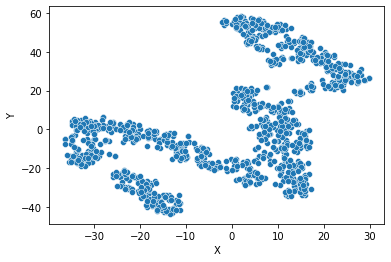

In [9]:
tsne = TSNE(n_components=2, random_state=0)

tsne_obj = tsne.fit_transform(normalized_df)
tsne_df = pd.DataFrame({'X':tsne_obj[:,0],
                        'Y':tsne_obj[:,1]})
sns.scatterplot(x="X", y="Y", data=tsne_df)

# Model

## Analysis

Brute

In [10]:
start = time.time()
nbrs = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(normalized_df)

end = time.time()
print(end - start)

0.001735687255859375


KD Tree

In [11]:
start = time.time()
nbrs = NearestNeighbors(n_neighbors=6, algorithm='kd_tree').fit(normalized_df)

end = time.time()
print(end - start)

0.0032482147216796875


Ball Tree

In [12]:
start = time.time()
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(normalized_df)

end = time.time()
print(end - start)

0.0019948482513427734


Conclusion:

Time [Brute] < Time [KD Tree] < Time [Ball Tree]

## Train

In [13]:
knn = NearestNeighbors(n_neighbors=6, algorithm='brute').fit(normalized_df)

## Saving

In [14]:
# Its important to use binary mode 
knnPickle = open(SAVING_MODEL, 'wb') 

# source, destination 
pickle.dump(knn, knnPickle)

## Loading

In [15]:
# load the model from disk
loaded_model = pickle.load(open(LOADING_MODEL, 'rb'))

> If you see this error: "EOFError: Ran out of input". You should try to run saving again.

# Result

In [16]:
df.reset_index(inplace=True)

In [17]:
# input
movie_id = df['movie_id'][1]
# load data-to-model
movie_index = df[df['movie_id'] == movie_id].index[0]
# check
test = df.set_index('movie_id').values[movie_index].reshape(1,-1)
result = loaded_model.kneighbors(test, return_distance=True)
result

(array([[1834.22914438, 1834.23446708, 1834.25338072, 1834.26334522,
         1834.26859718, 1834.2704971 ]]),
 array([[233,  18, 613, 656, 348, 592]]))

In [18]:
x = [_ for _ in result[1][0][1:]]
movie_info = movies

print('INPUT:\t', movie_info.loc[movie_index,:]['name'])
print('\nOUTPUT:\t', movie_info.loc[x,:]['name'].values)

INPUT:	 Ba wang bie ji

OUTPUT:	 ['My Name Is Khan' 'This Is Spinal Tap' 'Bound by Honor' 'Rossz versek'
 'Star Wars']
